<a href="https://colab.research.google.com/github/shraddha-an/nn-practice/blob/main/car_price_regression_nns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting Car Prices with Regression Neural Network**

## **1) Importing libraries**

In [ ]:
# Importing required libraries
# Data Handling/ Manipulation
import pandas as pd
import numpy as np

# Torch
import torch
import torch.nn as nn, torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# TensorFlow
import tensorflow as tf

# Time 
import time
from datetime import datetime as dt

# Plotting
import matplotlib.pyplot as plt
import seaborn as sb

In [ ]:
# Importing the dataset
dataset = pd.read_csv('car_data.csv')
print(dataset.info(),'\n\n')
dataset.head()

# Creating a metrics dict to hold MSE & MAE values for the models
metrics = {}

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB
None 




## **2) Data Preprocessing**
---
**Steps:**

1) Columns to encode: Fuel_Type, Seller_Type, Transmission

2) Feature Extraction: Extract Age of the vehicle from the Year column

3) Columns to delete: Car_Name, Year.






In [ ]:
# Calculating age in years of each vehicle
%time
dataset['Age'] = dataset['Year'].apply(lambda x: dt.today().year - x)

# Deleting car name & year columns
dataset.drop(columns = ['Car_Name', 'Year'], inplace = True)

# Splitting into feature & target matrices
X = dataset.iloc[:, 1:].values
y = dataset.iloc[:, 0].values.reshape(-1, 1)

# Splitting into train & test subsets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.2)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs


((240, 7), (240, 1), (61, 7), (61, 1))

In [ ]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer 

enc = LabelEncoder()

X_train[:, 2] = enc.fit_transform(X_train[:, 2])
X_test[:, 2] = enc.transform(X_test[:, 2])

X_train[:, 3] = enc.fit_transform(X_train[:, 3])
X_test[:, 3] = enc.transform(X_test[:, 3])

X_train[:, 4] = enc.fit_transform(X_train[:, 4])
X_test[:, 4] = enc.transform(X_test[:, 4])

# OHE the fuel_type column
ohe = ColumnTransformer([('encoder', OneHotEncoder(), [2])], remainder = 'passthrough') 

X_train = ohe.fit_transform(X_train)
X_test = ohe.transform(X_test)

# Standardization
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

len(X_test[0])

9

In [ ]:
len(X_train[0])

9

## **3) PyTorch Neural Network**

In [ ]:
# Converting numpy arrays to torch tensors of dtype float32
%time
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

train_data = TensorDataset(torch.tensor(X_train, dtype = torch.float32), torch.tensor(y_train, dtype = torch.float32))
test_data = TensorDataset(torch.tensor(X_test, dtype = torch.float32), torch.tensor(y_test, dtype = torch.float32))

# Creating data loader objects that'll supply batches of data to our model
train = DataLoader(dataset = train_data, sampler = RandomSampler(train_data), batch_size = 16)
test = DataLoader(dataset = test_data, batch_size = 1)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs


In [ ]:
# Defining the Regression Neural Network: 1 input layer, 1 hidden layer, 1 output layer
%time
class RegressionNN(nn.Module):
  # Defining our neural network architecture in the constructor 
  def __init__(self, input_dim):
    # Calling the correct parent constructors
    super().__init__()

    self.input1 = nn.Linear(in_features = input_dim, out_features = 100)
    self.hidden2 = nn.Linear(in_features = 100, out_features = 200)
    self.output3 = nn.Linear(in_features = 200, out_features = 1)

  # Defining forward pass computations
  def forward(self, x):
    x = F.relu(self.input1(x))
    x = F.relu(self.hidden2(x))
    x = self.output3(x)

    return x

# Creating an object of our neural network class
input_dim = len(X_train[0])
model = RegressionNN(input_dim = input_dim)
print(model)


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs
RegressionNN(
  (input1): Linear(in_features=9, out_features=100, bias=True)
  (hidden2): Linear(in_features=100, out_features=200, bias=True)
  (output3): Linear(in_features=200, out_features=1, bias=True)
)


In [ ]:
# Optimizer
from torch.optim import Adam

optimizer = Adam(params = model.parameters(), lr = 0.02, eps = 2e-3, amsgrad = True)

# Loss Function
criterion = nn.L1Loss()

In [ ]:
# Training loop
%time

# Putting model in train mode
model.train()

# Epochs 
epochs = 20

for epoch in range(epochs):
  print('\nEpoch {}/{}'.format(epoch + 1, epochs))
  print('------------')

  # Calculating training loss for every epoch
  train_loss = 0.0

  # Training batches
  for features, target in train:
    
    # Push variables to device
    features, target = features.to(device), target.to(device)

    # Clear out gradients from previous training batch
    optimizer.zero_grad()

    # Forward pass; feed inputs to model & get outputs
    outputs = model(features)

    # Calculate loss between model's predictions & actual target
    loss = criterion(outputs, target)
    train_loss += loss.item()

    # Back propagate loss throughout the neural network
    loss.backward()

    # Update parameters based on the current gradient
    optimizer.step()
  
  print('Training Loss: ', train_loss/len(train))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs

Epoch 1/20
------------
Training Loss:  2.151266161600749

Epoch 2/20
------------
Training Loss:  1.171347399552663

Epoch 3/20
------------
Training Loss:  1.3965235332647958

Epoch 4/20
------------
Training Loss:  1.3046990354855856

Epoch 5/20
------------
Training Loss:  0.9239172955354055

Epoch 6/20
------------
Training Loss:  0.783041658004125

Epoch 7/20
------------
Training Loss:  0.9221491535504659

Epoch 8/20
------------
Training Loss:  1.0450846175352733

Epoch 9/20
------------
Training Loss:  0.7997021536032359

Epoch 10/20
------------
Training Loss:  1.0604480981826783

Epoch 11/20
------------
Training Loss:  0.7895046770572662

Epoch 12/20
------------
Training Loss:  0.6974691758553188

Epoch 13/20
------------
Training Loss:  0.6274674971898396

Epoch 14/20
------------
Training Loss:  0.7668930311997731

Epoch 15/20
------------
Training Loss:  0.5540408968925477

Epoch 16/20
------------
Trainin

In [ ]:
# Testing loop
%time

# Variables to track predictions & target
preds, targets = [], []

# Putting model in test mode
model.eval()

# Disabling gradient calculation with no_grad(). Deactivates auto_grad engine 
# and reduces memory usage and speeds up computations but back propagation not possible.
with torch.no_grad():
  for features, target in test:

    # Pushing data to the device
    features = features.to(device)

    # Perform forward pass, collect outputs
    output = model(features)

    # Deatch predictions from the graph and append to list
    preds.append(output.detach().cpu().numpy())
    targets.append(target.to('cpu').numpy())

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


In [ ]:
# Converting preds to a simple list from a list of arrays
preds = [x[0][0] for x in preds]
y_test = [x for x in y_test]

# Calculating MAE & MSE between predictions & target
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, preds)
mse = mean_squared_error(y_test, preds)

# Adding these metrics to the metrics dict
metrics['PyTorch'] = {'mae': mae, 'mse': mse}

print('Mean Absolute Error: {}\nMean Squared Error: {}'.format(mae, mse) )

Mean Absolute Error: 0.8268836386868211
Mean Squared Error: 1.421962835181091


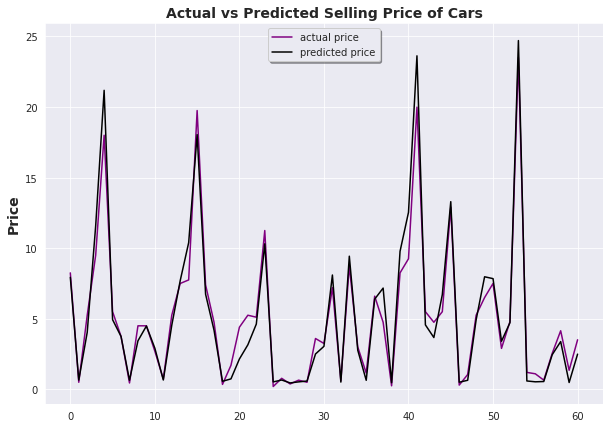

In [ ]:
# Plotting the target variable
sb.set_style('darkgrid')
plt.figure(figsize = (10, 7))

plt.plot(y_test, color = 'purple', label = 'actual price')
plt.plot(preds, color = 'black', label = 'predicted price')
plt.legend(shadow = True, loc = 'upper center')
plt.title('Actual vs Predicted Selling Price of Cars', fontsize = 14, fontweight = 'semibold')
plt.ylabel('Price', fontsize = 14, fontweight = 'semibold')
plt.show()

## **4) Keras Neural Network**

In [ ]:
# Importing keras modules
from keras.models import Sequential
from keras.layers import Dense

regressor = Sequential()
regressor.add(Dense(units = 100, activation = 'relu', input_dim = input_dim))
regressor.add(Dense(units = 200, activation = 'relu'))
regressor.add(Dense(units = 1))

# Compiling the model with adam optimizer
regressor.compile(optimizer = 'adam', metrics = ['mean_squared_error'], loss = 'mean_squared_logarithmic_error')

# Training the model
history = regressor.fit(X_train, y_train, batch_size = 16, epochs = 20, verbose = 0)

# Evaluating on test set
y_pred = regressor.predict(X_test)

# Printing metrics
mae_k = mean_absolute_error(y_test, y_pred)
mse_k = mean_squared_error(y_test, y_pred)

# Adding these metrics to the metrics dict
metrics['Keras'] = {'mae': mae_k, 'mse': mse_k}

print('MAE: {}\nMSE: {}'.format(mae_k, mse_k))

MAE: 0.6985253744828896
MSE: 1.1324348410208709


## **5) TensorFlow Neural Network**

In [ ]:
# Creating tf dataset with batches of data
batch_size = 16

train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_data = train_data.batch(batch_size = batch_size)

test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_data = test_data.batch(batch_size = len(X_test))

In [ ]:
# Creating a neural network class that subclasses the base Model class
from tensorflow.keras import Model, losses, optimizers
from tensorflow.keras.layers import Dense
import tensorflow.nn

class Regression(Model):
  # Defining layer architecture in the constructor
  def __init__(self):
    super().__init__()

    self.input1 = Dense(units = 100, activation = tf.nn.relu)
    self.hidden2 = Dense(units = 200, activation = tf.nn.relu)
    self.output3 = Dense(units = 1)

  # Defining forward pass computations
  def call(self, x):
    x = self.input1(x)
    x = self.hidden2(x)
    x = self.output3(x)

    return x

# Creating an object of the regression class defined above
reg = Regression()

# Loss function
loss_object = losses.MeanAbsoluteError()

# Optimizer
optimizer = optimizers.Adam()

# Metrics to measure loss during training & testing
train_loss = tf.keras.metrics.Mean(name = 'train_loss')
train_mse = tf.keras.metrics.MeanSquaredError(name = 'train_mse')
train_mae = tf.keras.metrics.MeanAbsoluteError(name = 'train_mae')

test_loss = tf.keras.metrics.Mean(name = 'test_loss')
test_mse = tf.keras.metrics.MeanSquaredError(name = 'test_mse')
test_mae = tf.keras.metrics.MeanAbsoluteError(name = 'test_mae')

In [ ]:
# Simple Training loop
%time
epochs = 20
# Iterate over each epoch
for epoch in range(epochs):
  print('Epoch {}/{}'.format(epoch + 1, epochs))
  
  # Iterate over the batches in the train dataset
  for step, (x, y) in enumerate(train_data):
  
    # Open tf.GradientTape to record the forward pass computations and enable auto-differentiation.
    with tf.GradientTape() as tape:

      # Compute forward pass by feeding the model the input data
      outputs = reg(x)

      # Compute loss
      loss = loss_object(y, outputs)
    
    # Use the gradient tape to automatically retrieve
    # the gradients of the trainable variables with respect to the loss.
    grads = tape.gradient(loss, reg.trainable_weights)

    # Run one step of gradient descent by updating
    # the value of the variables to minimize the loss.
    optimizer.apply_gradients(zip(grads, reg.trainable_weights))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


In [ ]:
# Simple testing loop
for x, y in test_data:
  
  # Feed inputs to model
  output = reg(x)

  # Compute loss
  test_mae.update_state(y, output)
  test_mse.update_state(y, output)

  mae_test = test_mae.result().numpy()
  mse_test = test_mse.result().numpy()

# Adding these metrics to the metrics dict
metrics['TensorFlow'] = {'mae': mae_test, 'mse': mse_test}

print('MAE: {}\nMSE: {}'.format(mae_test, mse_test))

MAE: 0.5989264249801636
MSE: 0.8686699867248535


In [ ]:
metrics

{'Keras': {'mae': 0.6985253744828896, 'mse': 1.1324348410208709},
 'PyTorch': {'mae': 0.8268836386868211, 'mse': 1.421962835181091},
 'TensorFlow': {'mae': 0.5989264, 'mse': 0.86867}}

In [ ]:
# Defining a training function
@tf.function
def train_step(features, targets):
  # GradientTape keeps track of the computations being performed on the trainable variables
  with tf.GradientTape() as tape:
    
    # Perform forward pass; feed the model with input data
    predictions = reg(features)

    # Compute loss between model's predictions and the actual target values
    loss = loss_object(predictions, targets)

  # Calling tape.gradient calculates gradients of the trainable_variables wrt another variable, in this case, loss. 
  gradients = tape.gradient(loss, reg.trainable_variables)

  # Apply gradients to variables
  optimizer.apply_gradients(grads_and_vars = zip(gradients, reg.trainable_variables))

  # Calculate mean training loss (msle)
  train_loss(loss)

  # Calculate train MSE & MAE
  train_mse(predictions, targets)
  train_mae(predictions, targets)

# Testing function
@tf.function  
def test_step(features, targets):
  # Directly feed the inputs to the model
  preds = reg(features)

  # Calculate loss
  loss = loss_object(preds, targets)

  # Update test loss variable
  test_loss(loss)

  # Calculate test MSE, MAE
  test_mse(preds, targets)
  test_mae(preds, targets)

In [ ]:
train

<PrefetchDataset shapes: ((None, 9), (None, 1)), types: (tf.float64, tf.float64)>

In [ ]:
len(X_train)/ 16
pot

2077